In [1]:
import os
import mlflow
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plot
import temporal_fusion_transformers as tft

import mlflow_utils


os.environ["MLFLOW_TRACKING_URI"] = "https://mlflow-server-med-jupyter-central-dev.apps.dev.ocp.bisinfo.org"

import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(12, 4))
sns.mpl.rc("font", size=12)

In [2]:
exp_id = mlflow_utils.get_or_create_experiment("TFT")
parent_id = mlflow.search_runs(
    experiment_ids=exp_id,
    order_by=["created DESC"],
    filter_string = "`Run Name`='Parent run'",
    max_results=1
).run_id.values[0]
runs = mlflow.MlflowClient().search_runs(experiment_ids=exp_id, filter_string=f"tags.mlflow.parentRunId = '{parent_id}'")

In [3]:
models = {}
for run in runs:
    model_path = f"runs:/{run.info.run_id}/model"
    if "TFT" in run.info.run_name:
        model = mlflow_utils.load_keras_model(model_path)
    else:
        model=mlflow.statsmodels.load_model(model_path)
    models[run.info.run_name] = model


2024/02/23 13:25:27 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 1.26.4, required: numpy==1.26.3)
 - scipy (current: 1.12.0, required: scipy==1.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
100%|██████████| 1/1 [00:00<00:00, 138.91it/s]
/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 690ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 691ms/step
4/9 ━━━━━━━━━━━━━━━━━━━━ 3s 692ms/step

KeyboardInterrupt: 

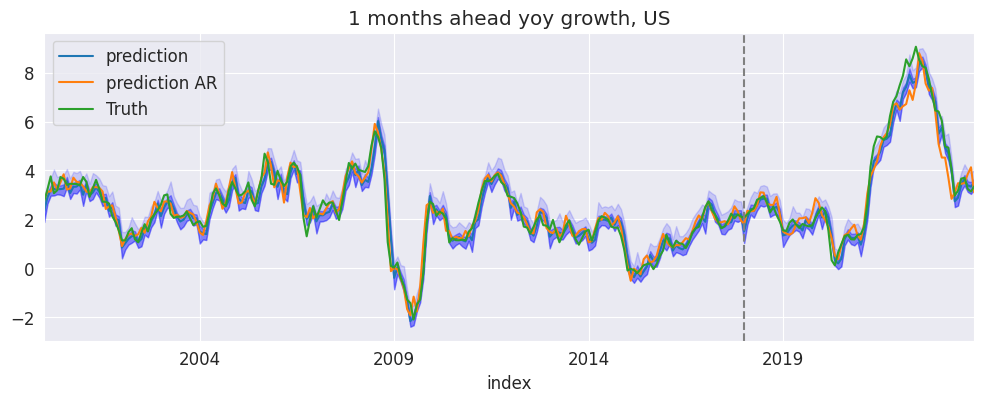

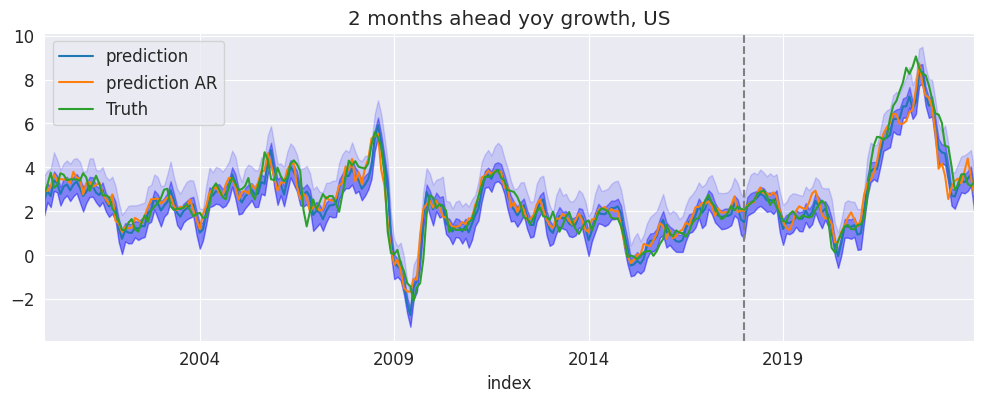

In [4]:
for n_months_ahead in [1, 2, 6, 12]:
    for country in ["US"]:
        plot.yoy_plot(models["TFT_full"], models[f"Autoreg_{country}"], "2000-01-01", "2023-12-01", country, n_months_ahead, True)

In [5]:
x = plot.create_predicition_sample("1980-01-01", "2023-01-01", "US")

In [6]:
predictions = models["TFT_full"].predict(x)

17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 694ms/step


[Text(0, 0.5, 'MoM inflation [%]'), Text(0.5, 1.0, 'US MoM inflation')]

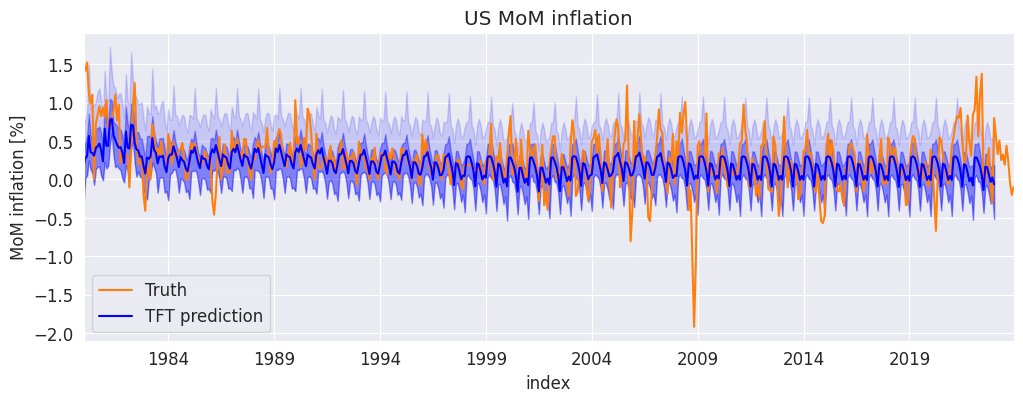

In [7]:
fig, ax = plt.subplots()
y = predictions[:,0,:]

pred_df = pd.DataFrame(
    data=y,
    columns=[f"quantile_{q:.2f}" for q in tft.quantiles],
    index=plot.create_monthly_index("1980-01-01", len(y)),
)

tft.df_target_1m_pct.loc["1980-01-01":,"US"].plot(color="C1", label="Truth")
pred_df["quantile_0.50"].plot(color="b", label="TFT prediction")

ax.fill_between(
    pred_df.index,
    pred_df["quantile_0.05"],
    pred_df["quantile_0.95"],
    color="b",
    alpha=0.15,
)
ax.fill_between(
    pred_df.index,
    pred_df["quantile_0.25"],
    pred_df["quantile_0.75"],
    color="b",
    alpha=0.35,
)
ax.legend()
ax.set(ylabel="MoM inflation [%]", title="US MoM inflation")

In [8]:
pyfunc_model = models["TFT_full"]
model = pyfunc_model.unwrap_python_model().model

In [9]:
model.tvars_hist.weights

[<KerasVariable shape=(22272, 87), dtype=float32, path=tft/historical_variable_selection/gated_residual_network_2/time_distributed/dense_35/kernel>,
 <KerasVariable shape=(87,), dtype=float32, path=tft/historical_variable_selection/gated_residual_network_2/time_distributed/dense_35/bias>,
 <KerasVariable shape=(22272, 256), dtype=float32, path=tft/historical_variable_selection/gated_residual_network_2/time_distributed_1/dense_36/kernel>,
 <KerasVariable shape=(256,), dtype=float32, path=tft/historical_variable_selection/gated_residual_network_2/time_distributed_1/dense_36/bias>,
 <KerasVariable shape=(256, 256), dtype=float32, path=tft/historical_variable_selection/gated_residual_network_2/time_distributed_2/dense_37/kernel>,
 <KerasVariable shape=(256, 87), dtype=float32, path=tft/historical_variable_selection/gated_residual_network_2/gated_linear_unit_6/time_distributed_3/dense_38/kernel>,
 <KerasVariable shape=(87,), dtype=float32, path=tft/historical_variable_selection/gated_residu

In [10]:
pred_df["quantile_0.50"] - tft.df_target_1m_pct.US

1980-01-01         NaN
1980-02-01   -1.137418
1980-03-01   -1.221287
1980-04-01   -0.557616
1980-05-01   -0.631720
                ...   
2023-08-01         NaN
2023-09-01         NaN
2023-10-01         NaN
2023-11-01         NaN
2023-12-01         NaN
Length: 528, dtype: float64

In [15]:
# Initialize variables to track the minimum RMSE and corresponding run
min_rmse = float('inf')
best_run_id = None

runs = mlflow.MlflowClient().search_runs(experiment_ids=exp_id, filter_string=f"tags.mlflow.parentRunId = 'b5e205747a5d4bf587f905749818f11f'")
for run in runs:
    try:
        rmse = run.data.metrics["val_loss"]  # Make sure your metric name matches
    except:
        continue
    if rmse < min_rmse:
        min_rmse = rmse
        best_run_id = run.info.run_id

In [16]:
model_path = f"runs:/{best_run_id}/model"
model = mlflow_utils.load_keras_model(model_path)

2024/02/23 13:27:40 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - numpy (current: 1.26.4, required: numpy==1.26.3)
 - scipy (current: 1.12.0, required: scipy==1.11.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 332 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
100%|██████████| 1/1 [00:00<00:00, 180.94it/s]
/opt/app-root/src/jupyter_workspace/share/nowcasting/NowcastML/nowcastenv/lib64/python3.9/site-packages/keras/src/saving/saving_lib.py:388: UserWarning: Skipping variable loading for optimizer 

In [17]:
model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.pyfunc.model
  run_id: f3ef0faff10540c985c68ea691598f11

In [ ]:
runs[3].info.run_name